<a href="https://colab.research.google.com/github/runnithan03/Dissertation/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Upload


In [ ]:
from google.colab import files
import os

uploaded = files.upload()

uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving final.csv to final.csv


Initial Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('clean.csv')

# Frequency encode categorical variables
for col in ['rating', 'category', 'risk_rating']:
    freq = data[col].value_counts() / len(data)
    data[col] = data[col].map(freq)

# Define features and target variables
X = data.drop(['roe', 'sustainability_score'], axis=1)
Y = data[['roe', 'sustainability_score']]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a single Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Predict on test data
Y_pred = rf_model.predict(X_test)
roe_pred = Y_pred[:, 0]
sus_pred = Y_pred[:, 1]

# Calculate ARSR
rsr_roe = np.mean(((roe_pred - Y_test['roe']) ** 2) / (Y_test['roe'] ** 2))
rsr_sus = np.mean(((sus_pred - Y_test['sustainability_score']) ** 2) / (Y_test['sustainability_score'] ** 2))

arsr_overall = (rsr_roe + rsr_sus) / 2

print(f'RSR for ROE: {rsr_roe:.4f}')
print(f'RSR for Sustainability Score: {rsr_sus:.4f}')
print(f'Overall RSR: {arsr_overall:.4f}')


RSR for ROE: 0.4619
RSR for Sustainability Score: 0.0094
Overall RSR: 0.2357


Random Forest Plot

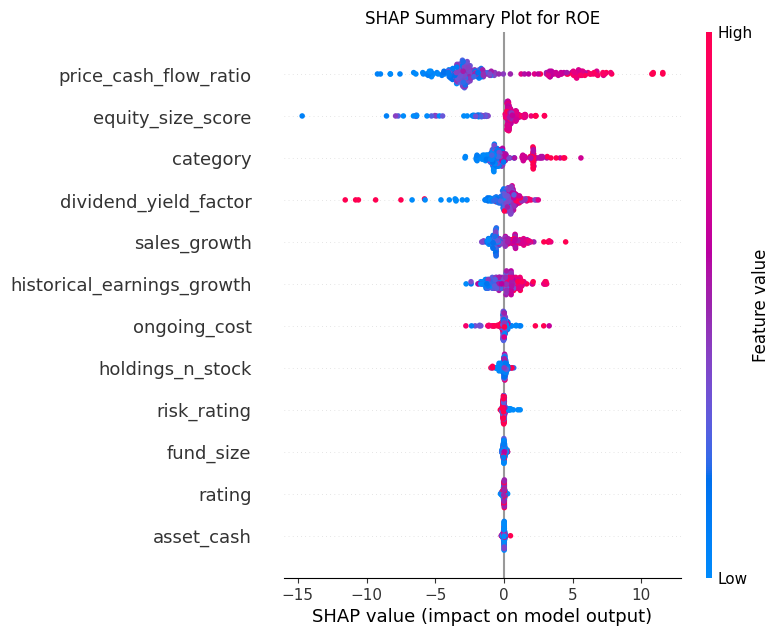

In [ ]:
import shap
import matplotlib.pyplot as plt

# TreeExplainer captures feature interactions
explainer = shap.TreeExplainer(rf_model)

# SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for roe
shap_roe = shap_values[:, :, 0]

# Create SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_roe, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot for ROE")
plt.show()

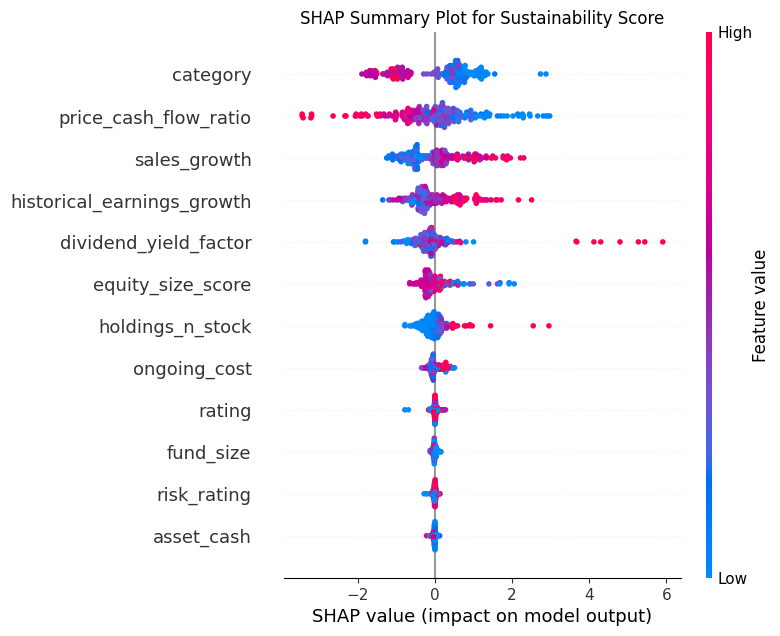

In [ ]:
import shap
import matplotlib.pyplot as plt

# TreeExplainer captures feature interactions
explainer = shap.TreeExplainer(rf_model)

# SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for the second target (sustainability_score)
shap_sus = shap_values[:, :, 1]  # Selects SHAP values for the second target

# Create SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_sus, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot for Sustainability Score")
plt.show()


Feature Importance

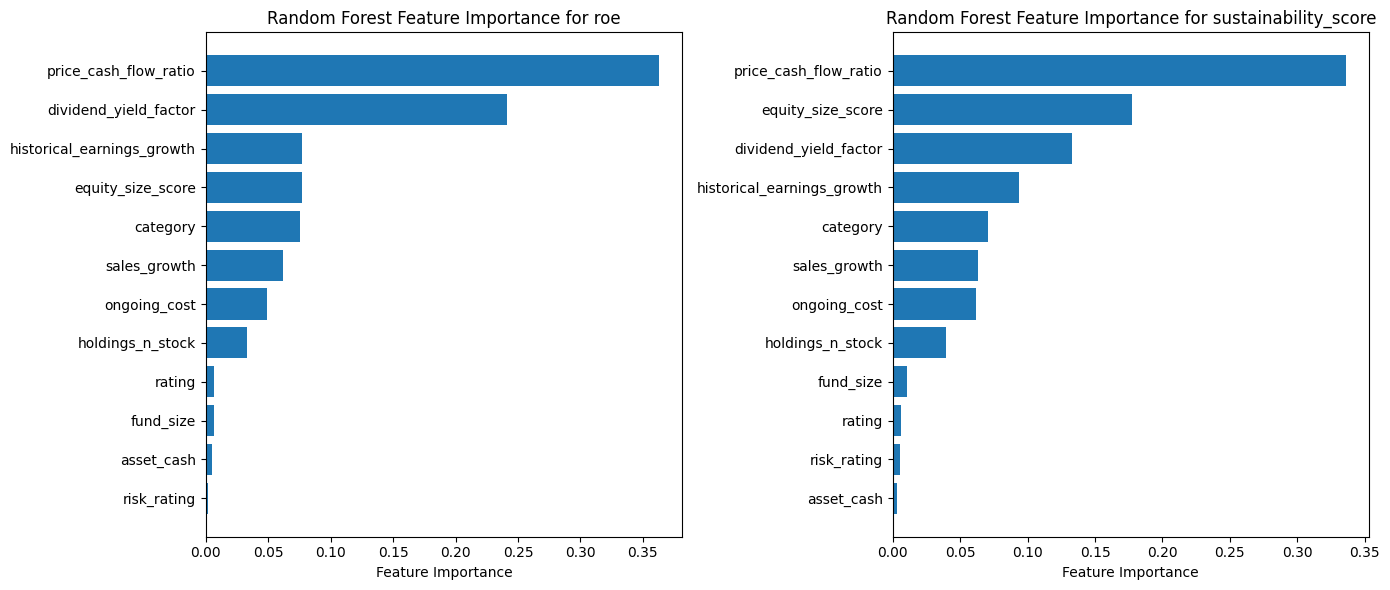

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For ROE
importances_roe = rf_model.estimators_[0].feature_importances_
indices_roe = np.argsort(importances_roe)[::-1]

# For Sustainability Score
importances_sus = rf_model.estimators_[1].feature_importances_
indices_sus = np.argsort(importances_sus)[::-1]

# Plot side by side
plt.figure(figsize=(14, 6))

# ROE Plot
plt.subplot(1, 2, 1)
plt.barh(range(X.shape[1]), importances_roe[indices_roe], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices_roe])  # Feature labels on Y-axis
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title("Random Forest Feature Importance for roe")
plt.xlabel("Feature Importance")

# Sustainability Score Plot
plt.subplot(1, 2, 2)
plt.barh(range(X.shape[1]), importances_sus[indices_sus], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices_sus])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance for sustainability_score")
plt.xlabel("Feature Importance")

plt.tight_layout()
plt.show()


More Advanced Model

In [ ]:
from google.colab import files
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap

# Upload the file
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]
os.rename(uploaded_filename, 'clean.csv')

Saving final.csv to final.csv


In [ ]:
# Load dataset
data = pd.read_csv('clean.csv')

# Frequency encode categorical variables
for col in ['rating', 'category', 'risk_rating']:
    freq = data[col].value_counts() / len(data)
    data[col] = data[col].map(freq)

# Define features and target variables
X = data.drop(['roe', 'sustainability_score'], axis=1)
y = data[['roe', 'sustainability_score']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train['roe'])

# Get the best model
best_model = grid_search.best_estimator_

# Train on the best model
best_model.fit(X_train, y_train['roe'])

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=500,
                      random_state=42)

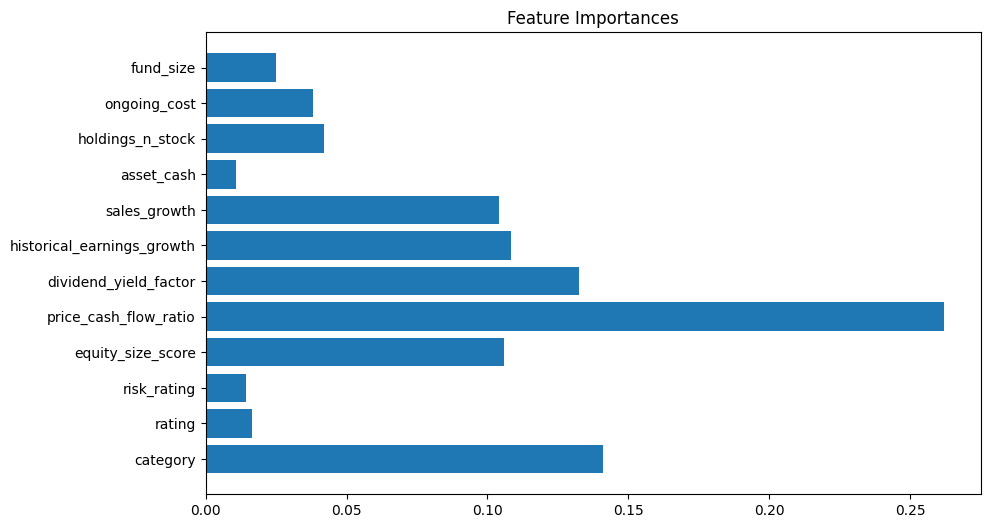

Cross-Validation Score (MSE): 8.800507889428369
RSR for ROE (Optimized): 1.0084


 99%|===================| 248/250 [00:56<00:00]       

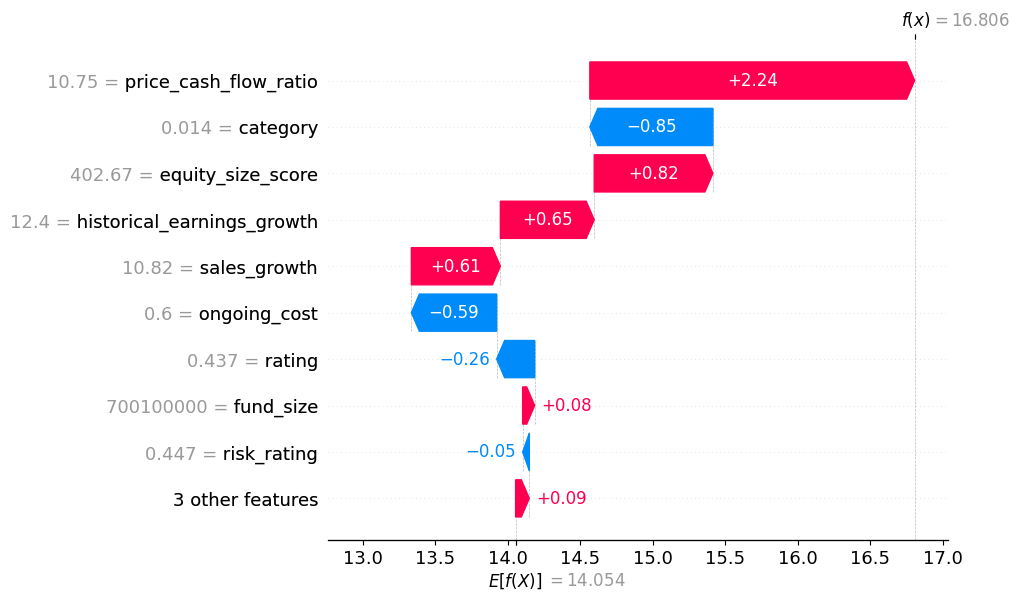

In [ ]:
# Feature importance visualization
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.title("Feature Importances")
plt.show()

# Cross-validation score
cv_scores = cross_val_score(best_model, X, y['roe'], cv=10, scoring='neg_mean_squared_error')
print("Cross-Validation Score (MSE):", -cv_scores.mean())

# Predict on test data
y_pred = best_model.predict(X_test)
roe_pred = y_pred
roe_true = y_test['roe']

# Calculate RSR
rsr_roe = np.mean(((roe_pred - roe_true) ** 2) / (roe_true ** 2))
print(f'RSR for ROE (Optimized): {rsr_roe:.4f}')

# SHAP explanations
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

RSR for Sustainability Score (Optimized): 0.0101


 98%|===================| 246/250 [00:51<00:00]       

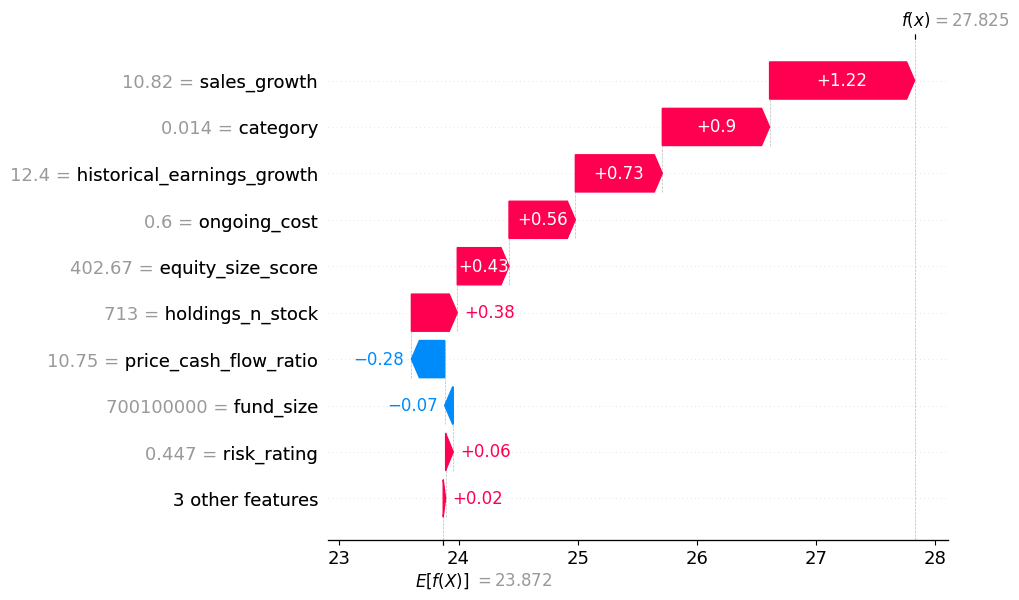

In [ ]:
# Sustainability Score (repeat similar process)
grid_search.fit(X_train, y_train['sustainability_score'])
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train['sustainability_score'])

sus_pred = best_model.predict(X_test)
sus_true = y_test['sustainability_score']

rsr_sus = np.mean(((sus_pred - sus_true) ** 2) / (sus_true ** 2))
print(f'RSR for Sustainability Score (Optimized): {rsr_sus:.4f}')

explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

In [ ]:
# Overall RSR
arsr_overall = (rsr_roe + rsr_sus) / 2
print(f'Overall RSR (Optimized): {arsr_overall:.4f}')

Overall RSR (Optimized): 0.5093
